<a href="https://colab.research.google.com/github/honlai/Financial_Mathematics_I/blob/main/Trade_with_RB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##More notes in [Risk_Parity_and_Budgeting](https://github.com/honlai/Financial_Mathematics_I/blob/main/Risk_Parity_and_Budgeting.ipynb)

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

class MyTrade():
  def __init__(self,arg_stocks_list=['2330.TW','2337.TW','2357.TW','2454.TW','3231.TW','3443.TW'],arg_begin='2015-01-01',arg_end='2023-10-01'):
    #股票代號
    self.__stocks_list=arg_stocks_list
    #['2330.TW','2337.TW','2357.TW','2454.TW','3231.TW','3443.TW']
    #['2330.TW','2357.TW','2454.TW','3231.TW']
    #['TSM','AAPL','GOOG','MSFT','AMZN','GOOGL']

    #開始日期
    self.__start_date=arg_begin
    #完結日期
    self.__end_date=arg_end
    #股票數
    self.__N=len(self.__stocks_list)
    #次數
    self.__M=0#len(data)

    # 創建一個空的的主數據框data
    self.__data = pd.DataFrame()
    for stock in self.__stocks_list:
        # yf.download(股票代號,start=開始日期,end=完結日期)
        # yf.download(股票代號,period=日期範圍(1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max),
        #         interval=頻率(1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo))
        df=yf.download(stock,start=self.__start_date,end=self.__end_date)
        df=df[['Adj Close']]#調整後收盤價
        df=df.rename(columns = {'Adj Close': stock})
        if self.__data.empty:
            self.__data = df
        else:
            self.__data=pd.concat([self.__data, df], axis=1)
        print(stock)

    self.__M=len(self.__data)
    #self.__data.plot()
    self.__train_date_len=int(self.__M/3)



    self.__crpd_rtn = pd.DataFrame()
    for stock in self.__stocks_list:
      tmp=pd.DataFrame({stock:self.__data[stock]})
      i=1
      for price in self.__data[stock][:-1]:
        tmp[stock][i]/=price
        i+=1
      tmp[stock][0]=1
      self.__crpd_rtn=pd.concat([self.__crpd_rtn, tmp], axis=1)
    self.__crpd_rtn_cumprod=self.__crpd_rtn.cumprod(axis = 0)

    self.__w_test=np.ones(self.__N)
    self.__w_test*=0.25

    self.set_basic_elements(self.__crpd_rtn)
    self.__r=self.__expected_rtn
    self.__c=1
    self.__risk_budget=np.ones(self.__N)
    self.__risk_budget/=self.__N

    self.__ld=1

  def get_e_rtn(self,arg_crpd_rtn):
    self.__expected_rtn=arg_crpd_rtn.mean()
    return

  def get_crl_matrix(self,arg_crpd_rtn):
    self.__correlation_matrix = np.corrcoef(arg_crpd_rtn,None,False)
    return
  def get_std(self,arg_crpd_rtn):
    self.__std_dev = np.std(arg_crpd_rtn)
    return
  def get_cov(self,arg_crpd_rtn):
    self.__covariance_matrix = np.zeros([self.__N,self.__N])
    for i in range(self.__N):
      for j in range(self.__N):
        self.__covariance_matrix[i][j]=self.__correlation_matrix[i][j]*self.__std_dev[i]*self.__std_dev[j]
    return

  def set_basic_elements(self,arg_crpd_rtn):
    self.get_e_rtn(arg_crpd_rtn)
    self.get_crl_matrix(arg_crpd_rtn)
    self.get_std(arg_crpd_rtn)
    self.get_cov(arg_crpd_rtn)
    return

  '''
  def set_parameters(self,arg_r=0,arg_c=1,arg_b=0):
    #ERC
    self.__r=arg_r
    self.__c=1
    #sum(b)=1
    self.__risk_budget=np.ones(self.__N)
    self.__risk_budget/=self.__N

    self.__ld=1
  '''

  def get_pvol(self,arg_w):
    """Get the portfolio volatility: (w.T * cov * w.)**0.5 """
    sigma=(arg_w.T.dot(self.__covariance_matrix.dot(arg_w)))**0.5
    return sigma
  def std_dev_b_risk_measure(self,arg_w):
    """Get the standard deviation-based risk measure: R(w)"""
    R=-arg_w.T.dot(self.__expected_rtn-self.__r)+self.__c*self.get_pvol(arg_w)
    return R
  def risk_contribution(self,arg_w):
    """Get the risk contribution: RCi(w)"""
    RC=np.zeros(self.__N)
    for i in range(self.__N):
      RCi=arg_w[i]*(-(self.__expected_rtn-self.__r)+self.__c*(self.__covariance_matrix.dot(arg_w)[i])/self.get_pvol(arg_w))
      #RCi=risk_budget[i]*std_dev_b_risk_measure(arg_w)
      RC[i]+=RCi[0]
    return RC

  def get_df(self,arg_w):
    df = np.zeros(self.__N)
    RC=self.risk_contribution(arg_w)
    for i in range(self.__N):
      df[i]=RC[i]/arg_w[i]-self.__ld*(self.__risk_budget[i]/arg_w[i])

    return df

  def get_ddf(self,arg_w):
    ddf = np.zeros([self.__N,self.__N])
    for i in range(self.__N):
      for j in range(self.__N):
        if j==i:
          ddf[i][j]=(self.__c/self.get_pvol(arg_w))*\
                (self.__std_dev[i]**2-((self.__covariance_matrix.dot(arg_w)[i])**2/(self.get_pvol(arg_w)**2)))+\
                  self.__ld*self.__risk_budget[i]/arg_w[i]**2
        else:
          ddf[i][j]=(self.__c/self.get_pvol(arg_w))*\
                (self.__covariance_matrix[i][j]-((self.__covariance_matrix.dot(arg_w)[i])*(self.__covariance_matrix.dot(arg_w)[j]))/(self.get_pvol(arg_w)**2))
    return ddf

  def netwon(self,tor,Nmax):
    w=[self.__w_test]
    error=1
    for i in range(Nmax):
      if error < tor:
        break
      tmp=w[i]-np.linalg.inv(self.get_ddf(w[i])).dot(self.get_df(w[i]))
      w.append(tmp)
      error=abs(sum(w[i]-w[i-1]))
    return pd.DataFrame({'weight':w[-1]/np.sum(w[-1])},self.__stocks_list)

  def ccd(self,tor,Nmax):
    w=[self.__w_test]
    error=1
    for k in range(Nmax):
      if error < tor:
        break
      tmp=np.zeros(self.__N)
      for i in range(self.__N):
        sigma=self.get_pvol(w[k])
        wps=0
        for j in range(self.__N):
          if j==i:
            continue
          wps+=w[k][j]*\
            self.__correlation_matrix[i][j]*\
            self.__std_dev[j]
        #print(-c*(std_dev[i]*wps)/(2*c*std_dev[i]*std_dev[i]))
        #print((expected_rtn-r)[i]*sigma/(2*c*std_dev[i]*std_dev[i]))
        #print(((c*(std_dev[i]*wps)-(expected_rtn-r)[i]*sigma)**2+ \
        #    (4*ld*c*risk_budget[i]*std_dev[i]*std_dev[i]*sigma))**(1/2)/ \
        #      (2*c*std_dev[i]*std_dev[i]))
        tmp[i]=-self.__c*(self.__std_dev[i]*wps)/(2*self.__c*self.__std_dev[i]*self.__std_dev[i])+ \
            (self.__expected_rtn-self.__r)[i]*sigma/(2*self.__c*self.__std_dev[i]*self.__std_dev[i])+ \
            ((self.__c*(self.__std_dev[i]*wps)-(self.__expected_rtn-self.__r)[i]*sigma)**2+ \
              (4*self.__ld*self.__c*self.__risk_budget[i]*self.__std_dev[i]*self.__std_dev[i]*sigma))**(1/2)/ \
                (2*self.__c*self.__std_dev[i]*self.__std_dev[i])
      w.append(tmp)
      error=abs(sum(w[k]-w[k-1]))
    return pd.DataFrame({'weight':w[-1]/np.sum(w[-1])},self.__stocks_list)

  def period_change(self,arg_interval=1):
    self.__all_assets=10000000
    self.__assets=np.ones(self.__N)
    self.__assets*=self.__all_assets/self.__N
    interval=arg_interval
    f_assets=np.array([])
    prev_i=self.__train_date_len
    self.set_basic_elements(self.__crpd_rtn[:prev_i])
    tmp=self.netwon(10**-11,100)
    for i in range(self.__N):
      self.__assets[i]=self.__all_assets*tmp['weight'][i]
    for i in range(self.__train_date_len,self.__M):
      if (i%interval):
        continue
      else:
        self.set_basic_elements(self.__crpd_rtn[:i])
        tmp=self.netwon(10**-11,100)

        self.__all_assets=np.sum(self.__assets)
        for j in range(self.__N):
          self.__assets[j]=self.__all_assets*tmp['weight'][self.__stocks_list[j]]

        for j in range(self.__N):
          self.__assets[j]/=self.__crpd_rtn_cumprod[self.__stocks_list[j]][prev_i]
          self.__assets[j]*=self.__crpd_rtn_cumprod[self.__stocks_list[j]][i]

        f_assets=np.append(f_assets,np.sum(self.__assets))
        prev_i=i
    f_rtn=pd.DataFrame({'asset':f_assets})
    f_rtn
    i=1
    for k in f_assets[:-1]:
      f_rtn['asset'][i]=f_assets[i]/k
      i+=1
    f_rtn['asset'][0]=1
    f_rtn_cumprod=f_rtn.cumprod(axis = 0)
    f_rtn.plot()
    f_rtn_cumprod.plot()
    print(f_rtn_cumprod['asset'][len(f_rtn_cumprod)-1])
    return
mytrade=MyTrade()

[*********************100%%**********************]  1 of 1 completed
2330.TW
[*********************100%%**********************]  1 of 1 completed
2337.TW
[*********************100%%**********************]  1 of 1 completed
2357.TW
[*********************100%%**********************]  1 of 1 completed
2454.TW
[*********************100%%**********************]  1 of 1 completed
3231.TW
[*********************100%%**********************]  1 of 1 completed
3443.TW


3.6174261403433445


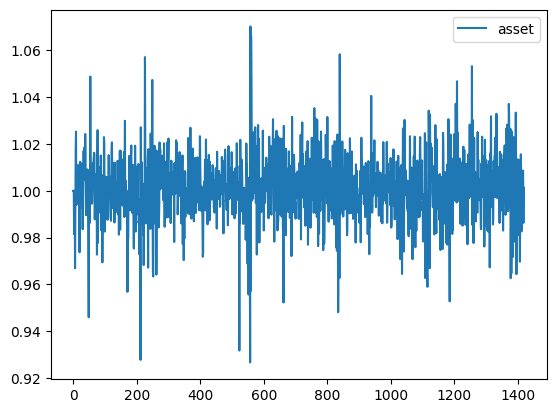

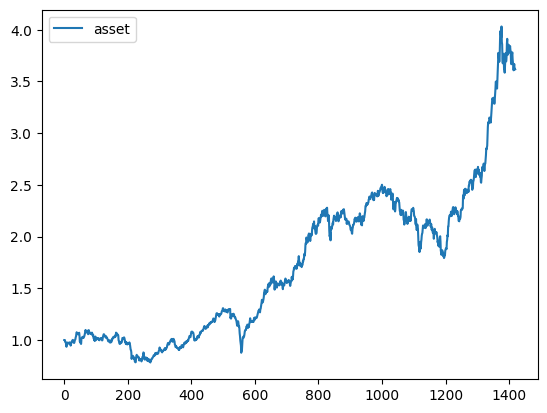

In [52]:
#daily
mytrade.period_change(1)

3.6500622357866255


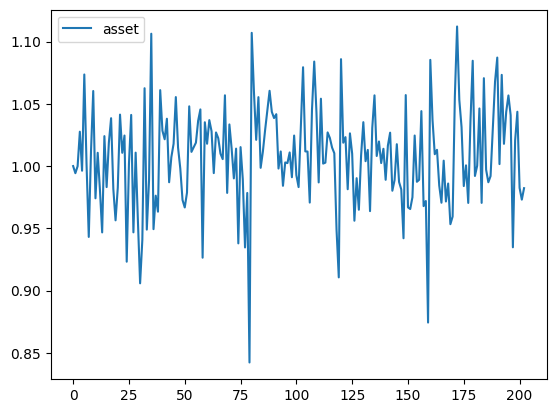

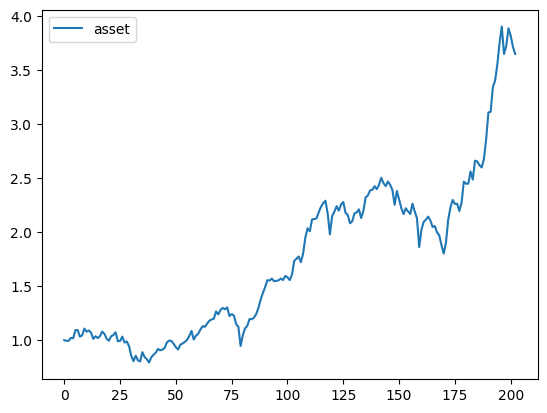

In [53]:
#weekly
mytrade.period_change(7)

3.6584316803831802


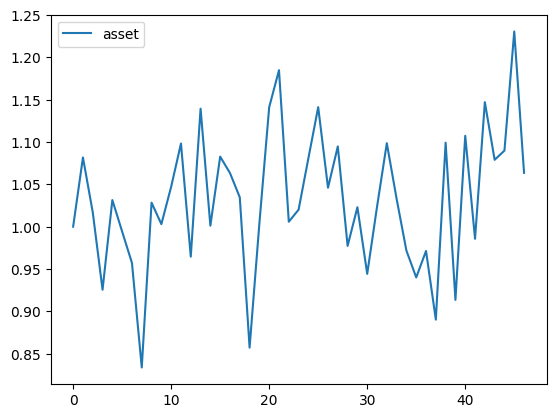

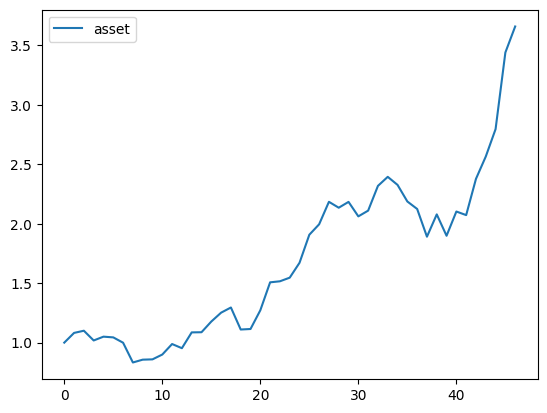

In [54]:
#monthly
mytrade.period_change(30)

3.7478158192940203


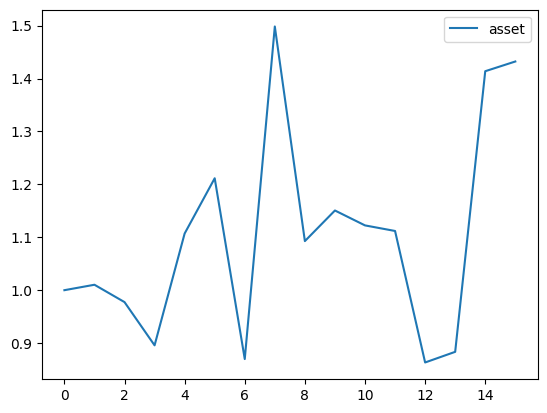

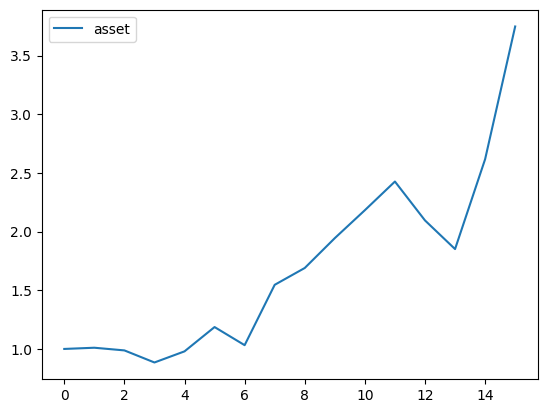

In [55]:
#quarterly
mytrade.period_change(91)

1.9885905386349112


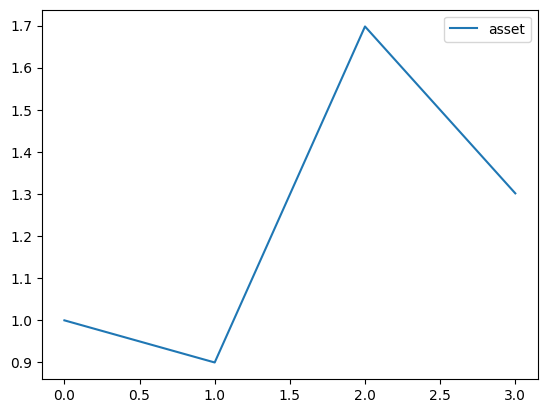

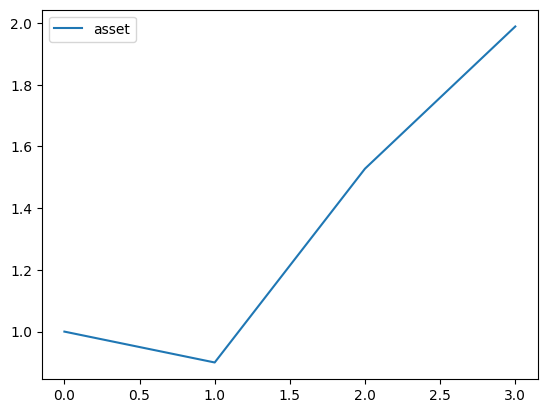

In [56]:
#annually
mytrade.period_change(356)